# **Interpretability and Business Impact**

## 1. Selected Model

In [6]:
# Recreate model Random Forest (Threshold Tuned) from Notebook 2

import os
os.makedirs('../reports/figures', exist_ok=True)
SAVE_PATH = '../reports/figures/'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

df = pd.read_csv('../data/online_shoppers_intention.csv')

X = df.drop('Revenue', axis=1)
y = df['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

def engineer_features(X):
    """Apply same feature engineering as Notebook 02"""
    X = X.copy()
    
    # Total duration
    X['total_duration'] = (X['Administrative_Duration'] + 
                          X['Informational_Duration'] + 
                          X['ProductRelated_Duration'])
    
    # Has page value (binary indicator)
    X['has_pagevalue'] = (X['PageValues'] > 0).astype(int)
    
    # Product focus
    X['product_focus'] = X['ProductRelated_Duration'] / (X['total_duration'] + 1)
    
    # PageValue × ExitRate interaction
    X['pagevalue_exit_interaction'] = X['PageValues'] * (1 - X['ExitRates'])
    
    # Engagement rate
    total_pages = X['Administrative'] + X['Informational'] + X['ProductRelated']
    X['engagement_rate'] = X['total_duration'] / (total_pages + 1)
    
    # Total pages
    X['total_pages'] = X['Administrative'] + X['Informational'] + X['ProductRelated']
    
    return X

X_train = engineer_features(X_train)
X_test = engineer_features(X_test)

numerical_features = [
    'PageValues', 'ExitRates', 'BounceRates', 'total_duration',
    'product_focus', 'engagement_rate', 'has_pagevalue',
    'pagevalue_exit_interaction', 'total_pages'
]

categorical_features = ['Month', 'VisitorType']
features_to_use = numerical_features + categorical_features

X_train_selected = X_train[features_to_use].copy()
X_test_selected = X_test[features_to_use].copy()

X_train_encoded = pd.get_dummies(X_train_selected, columns=['Month', 'VisitorType'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test_selected, columns=['Month', 'VisitorType'], drop_first=True)

scaler = StandardScaler()
scaler.fit(X_train_encoded[numerical_features])

X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

X_train_scaled[numerical_features] = scaler.transform(X_train_encoded[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test_encoded[numerical_features])

rf_model = RandomForestClassifier(
    max_depth=30,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
y_pred_threshold = (y_pred_proba >= 0.291).astype(int)

from sklearn.metrics import confusion_matrix, roc_auc_score, fbeta_score, precision_score, recall_score

auc = roc_auc_score(y_test, y_pred_proba)
recall = recall_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
f2 = fbeta_score(y_test, y_pred_threshold, beta=2)

print(f"\nModel Performance (Threshold=0.291):")
print(f"AUC: {auc:.4f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F2 Score: {f2:.4f}")

cm = confusion_matrix(y_test, y_pred_threshold)
print(f"\nConfusion Matrix:")
print(cm)
print(f"Buyers caught: {cm[1,1]}/572 ({cm[1,1]/572:.1%})")

Train set: (8631, 17), Test set: (3699, 17)

Model Performance (Threshold=0.291):
AUC: 0.9247
Recall: 0.87
Precision: 0.51
F2 Score: 0.7596

Confusion Matrix:
[[2646  481]
 [  76  496]]
Buyers caught: 496/572 (86.7%)


## 2. SHAP Analysis

In [11]:
explainer = shap.TreeExplainer(rf_model)
shap_explanation = explainer(X_test_scaled)

shap_values_purchase = shap_explanation.values[:, :, 1]
base_value = shap_explanation.base_values[:, 1]

### 2.1 SHAP Feature Importance

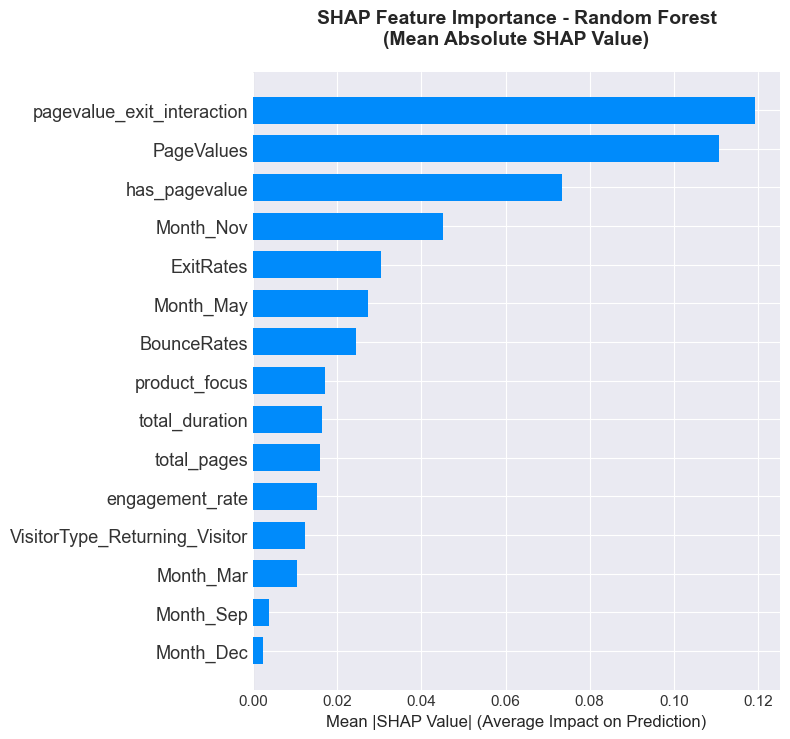

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values_purchase, X_test_scaled, 
                  plot_type="bar", show=False, max_display=15)
plt.title('SHAP Feature Importance - Random Forest\n(Mean Absolute SHAP Value)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mean |SHAP Value| (Average Impact on Prediction)', fontsize=12)
plt.tight_layout()
plt.savefig(f'{SAVE_PATH}shap_feature_importance_bar.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.2 SHAP Feature Impact Distribution

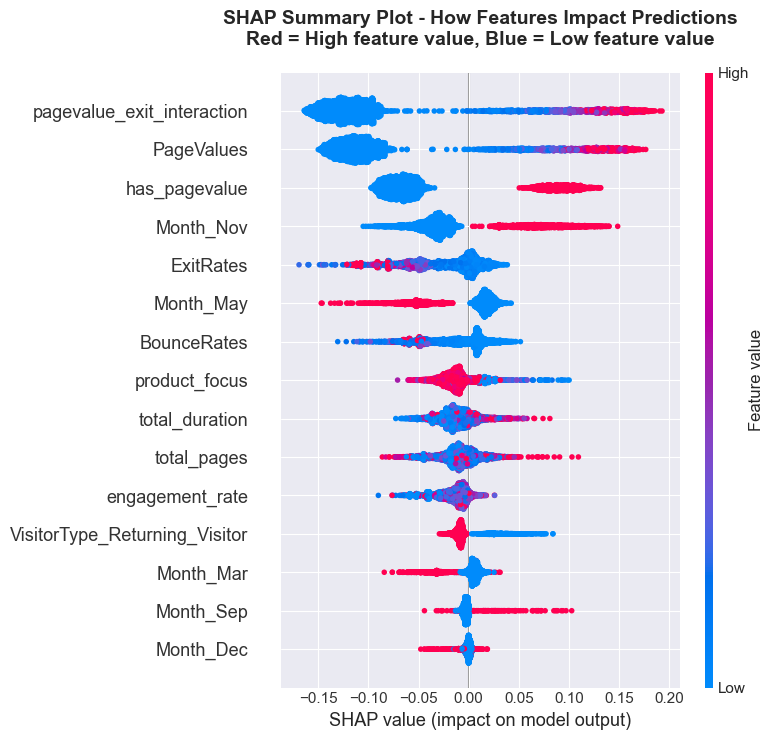

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
shap.summary_plot(shap_values_purchase, X_test_scaled, 
                  show=False, max_display=15)
plt.title('SHAP Summary Plot - How Features Impact Predictions\n' + 
          'Red = High feature value, Blue = Low feature value', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{SAVE_PATH}shap_summary_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Individual Prediction Case Analysis

2.3.1 Waterfall Plot: Confident Buyer


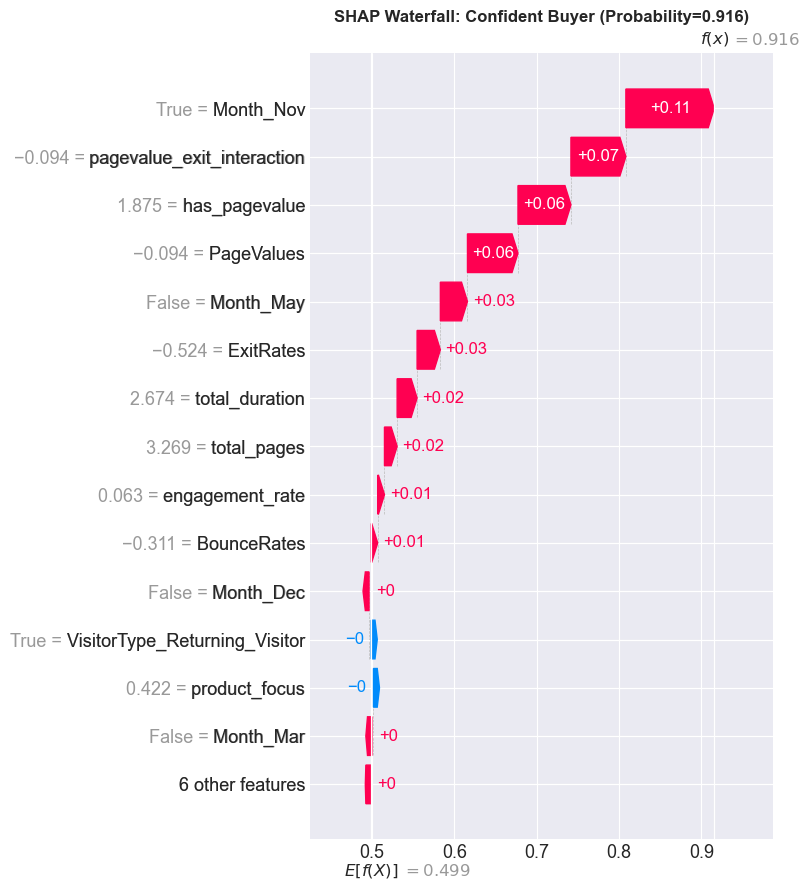

2.3.2 Waterfall Plot: Missed Buyer


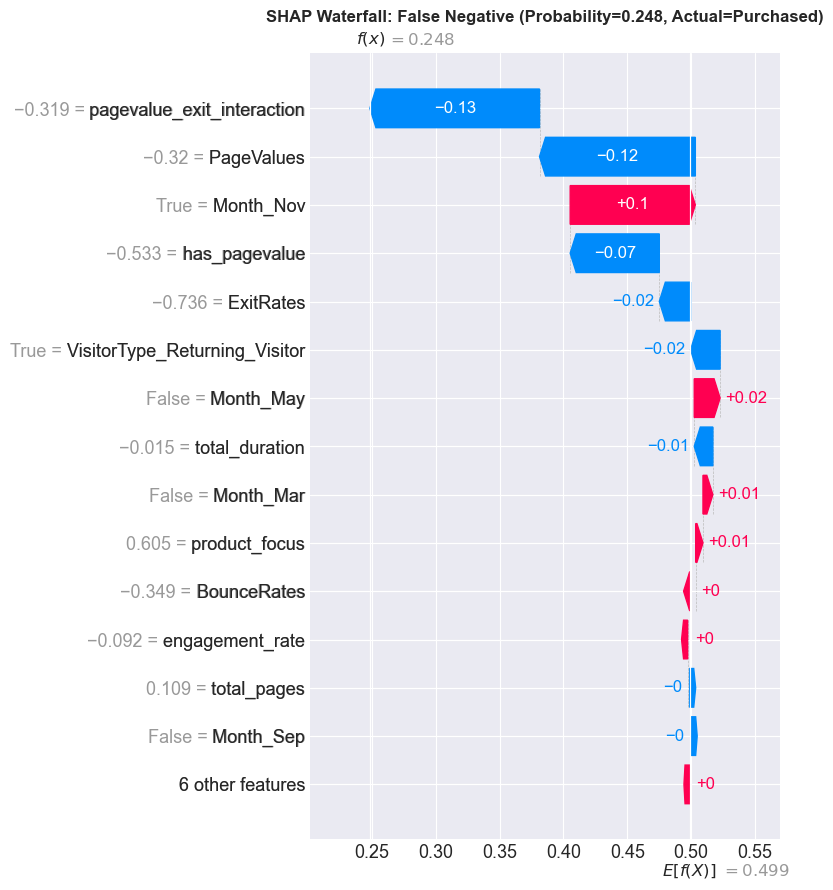

In [16]:
# High probability buyer who actually bought
high_prob_buyer = np.where((y_pred_proba > 0.8) & (y_test == 1))[0][0]

# False negative (predicted non-buyer, actually bought)
false_negative = np.where((y_pred_threshold == 0) & (y_test == 1))[0][0]

print("2.3.1 Waterfall Plot: Confident Buyer")

# Use the new API
shap.plots.waterfall(shap_explanation[high_prob_buyer, :, 1], max_display=15, show=False)
plt.title(f'SHAP Waterfall: Confident Buyer (Probability={y_pred_proba[high_prob_buyer]:.3f})', 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{SAVE_PATH}shap_waterfall_confident_buyer.png', dpi=300, bbox_inches='tight')
plt.show()

print("2.3.2 Waterfall Plot: Missed Buyer")

shap.plots.waterfall(shap_explanation[false_negative, :, 1], max_display=15, show=False)
plt.title(f'SHAP Waterfall: False Negative (Probability={y_pred_proba[false_negative]:.3f}, Actual=Purchased)', 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{SAVE_PATH}shap_waterfall_false_negative.png', dpi=300, bbox_inches='tight')
plt.show()